In [1]:
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
# Load pickle file with balanced dataframe
with open(r'pickles\balanced_retokenized.pickle', 'rb') as f:
    data = pickle.load(f)

### Representação vetorial (Tf-Idf)

In [6]:
# Split data into features (X) and label (y)
X_data = np.array(data['title'])
y_data = np.array(data['label'])

# Apply Tf-Idf representation
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer = vectorizer.fit(X_data)
X_data = vectorizer.transform(X_data)

### Redução de Dimensionalidade

#### Extração de Features (LSA - TruncatedSVD)

In [7]:
LSA = TruncatedSVD(n_components=100, n_iter=150, random_state=0)
LSA = LSA.fit(X_data)
X_data = LSA.transform(X_data)

## Modelagem de algoritmos

#### Naive Bayes

In [5]:
NB_classifier = GaussianNB()
print('Naive Bayes do not have hyperparameters')

Naive Bayes do not have hyperparameters


#### Logistic Regression

In [6]:
LR_classifier = LogisticRegression()
LR_hyperparameters = {
    'solver': ['lbfgs', 'sag', 'saga'],
    'C': [1, 10, 100, 1000], 
    'penalty': ["l2"],
    'max_iter': [1000]
}
LR_classifier = GridSearchCV(LR_classifier, LR_hyperparameters, cv=10, verbose=20, n_jobs = -1)
LR_classifier.fit(X_data, y_data)
print(f'Logistic Regression Best Params: {LR_classifier.best_params_}')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Logistic Regression Best Params: {'C': 1000, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


#### K-Nearest-Neighboors

In [7]:
KNN_classifier = KNeighborsClassifier()
KNN_hyperparameters = {
    'n_neighbors': list(range(3, 27, 2))
}
KNN_classifier = GridSearchCV(KNN_classifier, KNN_hyperparameters, cv=10, verbose=20, n_jobs = -1)
KNN_classifier.fit(X_data, y_data)
print(f'K-Nearest-Neighbors Best Params: {KNN_classifier.best_params_}')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
K-Nearest-Neighbors Best Params: {'n_neighbors': 3}


#### Support Vector Machine

In [8]:
SVM_classifier = SVC()
SVM_hyperparameters = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
    'probability': [True],
    'gamma': ['scale', 'auto'],
    'C': [1, 10, 100, 1000]
}
SVM_classifier = GridSearchCV(SVM_classifier, SVM_hyperparameters, cv=10, verbose=20, n_jobs = -1)
SVM_classifier.fit(X_data, y_data)
print(f'Support Vector Machine Best Params: {SVM_classifier.best_params_}')

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Support Vector Machine Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}


#### Multilayer Perceptron

In [9]:
MLP_classifier = MLPClassifier()
MLP_hyperparameters = {
    'hidden_layer_sizes': [(30,30,25), (100,50,25), (100,50,50,25), (100,50,50,25,12)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [1000]
}
MLP_classifier = GridSearchCV(MLP_classifier, MLP_hyperparameters, cv=10, verbose=20, n_jobs = -1)
MLP_classifier.fit(X_data, y_data)
print(f'Multilayer Perceptron Best Params: {MLP_classifier.best_params_}')

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Multilayer Perceptron Best Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 50, 25), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


In [ ]:
# #Save pickle file with balanced dataframe
# with open(r'pickles\model_NB.pickle', 'wb') as f:
#     pickle.dump(NB_classifier, f)
# with open(r'pickles\model_LR.pickle', 'wb') as f:
#     pickle.dump(LR_classifier, f)
# with open(r'pickles\model_KNN.pickle', 'wb') as f:
#     pickle.dump(KNN_classifier, f)
# with open(r'pickles\model_SVM.pickle', 'wb') as f:
#     pickle.dump(SVM_classifier, f)
# with open(r'pickles\model_MLP.pickle', 'wb') as f:
#     pickle.dump(MLP_classifier, f)

In [8]:
with open(r'pickles\model_NB.pickle', 'rb') as f:
    NB_classifier = pickle.load(f)

with open(r'pickles\model_LR.pickle', 'rb') as f:
    LR_classifier = pickle.load(f)

with open(r'pickles\model_KNN.pickle', 'rb') as f:
    KNN_classifier = pickle.load(f)

with open(r'pickles\model_SVM.pickle', 'rb') as f:
    SVM_classifier = pickle.load(f)
    
with open(r'pickles\model_MLP.pickle', 'rb') as f:
    MLP_classifier = pickle.load(f)

In [9]:
def metrics(classifier, cv):
    print(f'======= MODEL {classifier.__class__.__name__} =======')
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12,7))
    for i, (train, test) in enumerate(cv.split(X_data, y_data)):
        start_time = time.time()
        classifier.fit(X_data[train], y_data[train])
        predicted = classifier.predict(X_data[test])
        print(f'Cross-validate k={i}: precision={precision_score(predicted, y_data[test])}, recall={recall_score(predicted, y_data[test])}, f1={f1_score(predicted, y_data[test])}, time={time.time() - start_time}s')
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_data[test],
            y_data[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"ROC médio (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 desv. pad.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"ROC para o modelo {classifier.__class__.__name__} com validação cruzada 10-fold",
    )
    ax.legend(loc="lower right")
    ax.set_xlabel('Taxa de Falso Positivo (FP) (classe positiva: 1)', fontsize=12)
    ax.set_ylabel('Taxa de Verdadeiro Positivo (VP) (classe positiva: 1)', fontsize=12)
    plt.show()

======= MODEL GaussianNB =======
Cross-validate k=0: precision=0.7092409240924092, recall=0.7811704834605598, f1=0.7434699878913683, time=0.14919161796569824s
Cross-validate k=1: precision=0.762046204620462, recall=0.6851632047477745, f1=0.7215624999999999, time=0.14426064491271973s
Cross-validate k=2: precision=0.8056105610561056, recall=0.7702745345534869, f1=0.7875463784481367, time=0.14162158966064453s
Cross-validate k=3: precision=0.81809177946517, recall=0.722027972027972, f1=0.7670639219934994, time=0.1406257152557373s
Cross-validate k=4: precision=0.8240924092409241, recall=0.6633900106269925, f1=0.7350603473653223, time=0.13260769844055176s
Cross-validate k=5: precision=0.8181518151815181, recall=0.786984126984127, f1=0.8022653721682848, time=0.13760066032409668s
Cross-validate k=6: precision=0.7900990099009901, recall=0.7900990099009901, f1=0.7900990099009901, time=0.13364338874816895s
Cross-validate k=7: precision=0.7828382838283828, recall=0.7125262841694202, f1=0.746029249

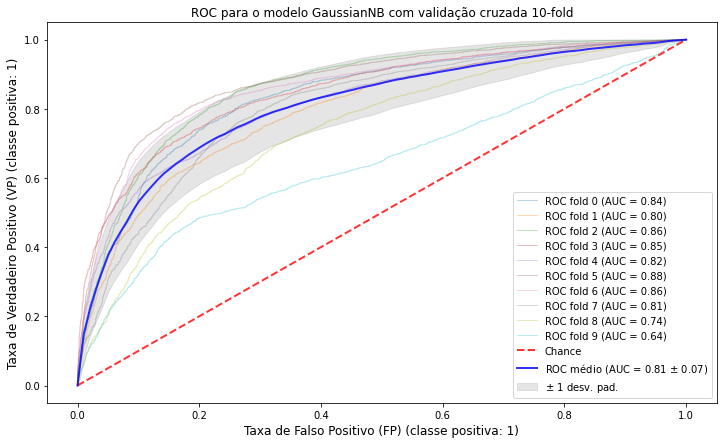

======= MODEL LogisticRegression =======
Cross-validate k=0: precision=0.693069306930693, recall=0.8842105263157894, f1=0.7770582793709528, time=1.089501142501831s
Cross-validate k=1: precision=0.766996699669967, recall=0.7757009345794392, f1=0.7713242615333554, time=1.0735106468200684s
Cross-validate k=2: precision=0.8376237623762376, recall=0.8080229226361032, f1=0.8225571220223628, time=1.0981385707855225s
Cross-validate k=3: precision=0.8213931990756025, recall=0.8431040325313454, f1=0.8321070234113713, time=1.0676755905151367s
Cross-validate k=4: precision=0.8481848184818482, recall=0.7878602084610669, f1=0.8169103623649078, time=1.066793441772461s
Cross-validate k=5: precision=0.8511551155115512, recall=0.9119519094766619, f1=0.8805052919085012, time=1.1238386631011963s
Cross-validate k=6: precision=0.7623762376237624, recall=0.9144893111638955, f1=0.8315334773218143, time=1.0695810317993164s
Cross-validate k=7: precision=0.7511551155115511, recall=0.8048090523338048, f1=0.777057

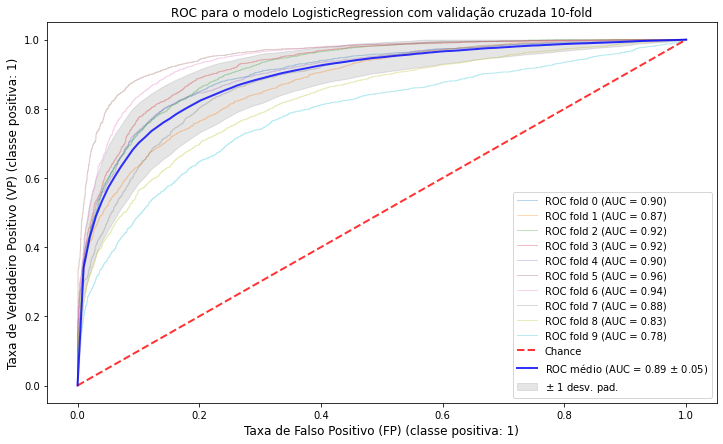

======= MODEL KNeighborsClassifier =======
Cross-validate k=0: precision=0.807920792079208, recall=0.8834355828220859, f1=0.8439924151008447, time=6.582469701766968s
Cross-validate k=1: precision=0.8745874587458746, recall=0.7969924812030075, f1=0.8339889850511407, time=6.2993786334991455s
Cross-validate k=2: precision=0.8805280528052806, recall=0.8194103194103194, f1=0.848870505886096, time=6.321640491485596s
Cross-validate k=3: precision=0.8732254869593925, recall=0.8573743922204214, f1=0.865227347072293, time=6.333186864852905s
Cross-validate k=4: precision=0.9211221122112211, recall=0.7937997724687145, f1=0.8527344943476933, time=6.445294380187988s
Cross-validate k=5: precision=0.9112211221122112, recall=0.9058398950131233, f1=0.9085225403093123, time=6.549284934997559s
Cross-validate k=6: precision=0.8933993399339935, recall=0.9080845353908085, f1=0.9006820828481119, time=6.55650520324707s
Cross-validate k=7: precision=0.8607260726072608, recall=0.8274111675126904, f1=0.8437398900

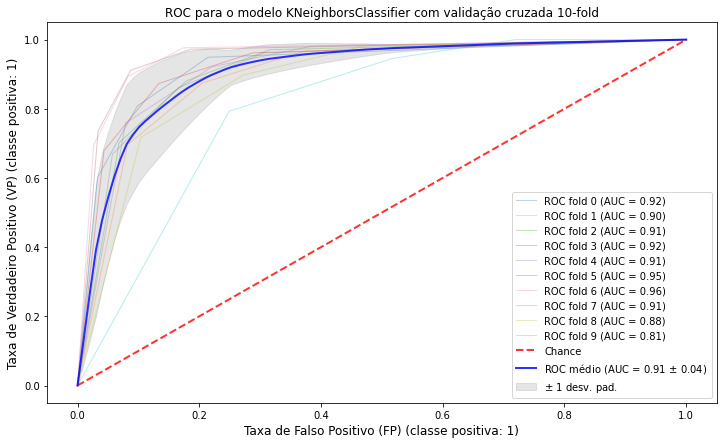

======= MODEL SVC =======
Cross-validate k=0: precision=0.8636963696369637, recall=0.9214788732394367, f1=0.8916524701873935, time=5106.4172620773315s
Cross-validate k=1: precision=0.9174917491749175, recall=0.8442150015183723, f1=0.8793294322315356, time=4973.391348361969s
Cross-validate k=2: precision=0.927062706270627, recall=0.8669753086419754, f1=0.896012759170654, time=4860.646387338638s
Cross-validate k=3: precision=0.9197755034664906, recall=0.8987096774193548, f1=0.9091205743188122, time=5172.028262615204s
Cross-validate k=4: precision=0.9432343234323433, recall=0.8761496014714899, f1=0.9084551811824538, time=4813.972056627274s
Cross-validate k=5: precision=0.9095709570957096, recall=0.9345540861308919, f1=0.9218932931928416, time=5186.005975008011s
Cross-validate k=6: precision=0.9122112211221122, recall=0.9325236167341431, f1=0.9222555889222555, time=5047.36045050621s
Cross-validate k=7: precision=0.8871287128712871, recall=0.8804454634785457, f1=0.8837744533947066, time=569

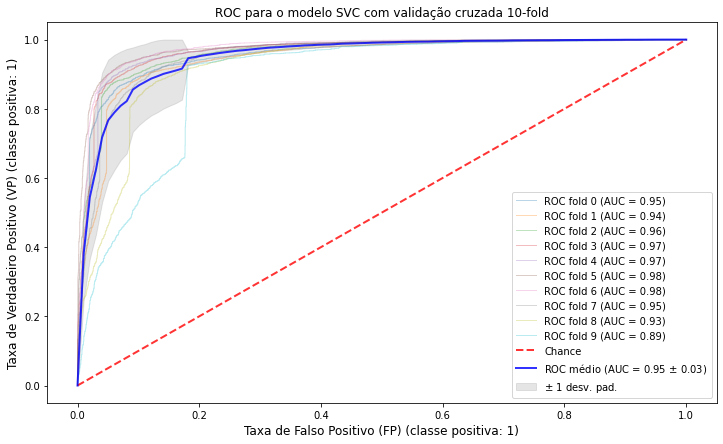

======= MODEL MLPClassifier =======
Cross-validate k=0: precision=0.8528052805280528, recall=0.9221984296930764, f1=0.8861454046639232, time=243.27802801132202s
Cross-validate k=1: precision=0.9042904290429042, recall=0.8723336517032793, f1=0.8880246313401393, time=407.5015354156494s
Cross-validate k=2: precision=0.9313531353135314, recall=0.8747675139491631, f1=0.9021739130434783, time=307.4089939594269s
Cross-validate k=3: precision=0.942885440739518, recall=0.8793103448275862, f1=0.9099888481758802, time=295.6642746925354s
Cross-validate k=4: precision=0.9521452145214522, recall=0.8485294117647059, f1=0.8973561430793158, time=316.26376509666443s
Cross-validate k=5: precision=0.9135313531353135, recall=0.9150413223140496, f1=0.9142857142857144, time=285.6292927265167s
Cross-validate k=6: precision=0.9145214521452145, recall=0.9270659083305454, f1=0.9207509553081907, time=340.26350712776184s
Cross-validate k=7: precision=0.8656765676567657, recall=0.8858493752110773, f1=0.875646803538

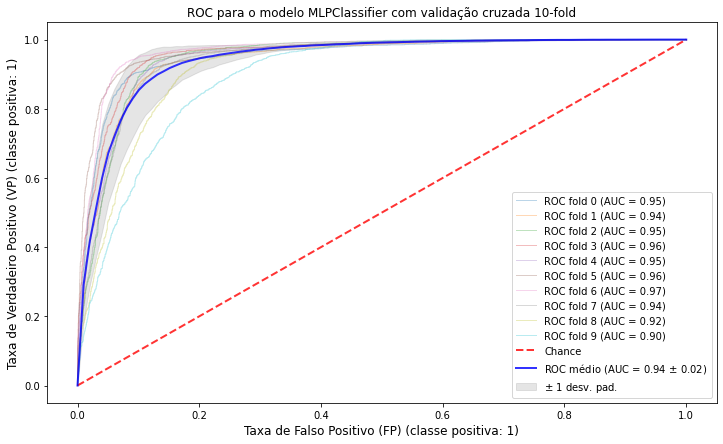

In [10]:
cv = StratifiedKFold(n_splits=10)
metrics(NB_classifier, cv)
metrics(LR_classifier.best_estimator_, cv)
metrics(KNN_classifier.best_estimator_, cv)
metrics(SVM_classifier.best_estimator_, cv)
metrics(MLP_classifier.best_estimator_, cv)